# Imports

## Imports

In [1]:
from IPython.display import display
import time

import datetime
import importlib
import re
import multiprocessing
import yaml
import os
import sys
import pickle

import scipy.stats
import random
import gzip
import os
import sys
import tempfile


import pandas as pd
import numpy as np
import itertools as itt

In [2]:
if not '/users/ldog/moyon/Thesis//scripts/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis//scripts/')

import dataframes
importlib.reload(dataframes)

import ML_tests
importlib.reload(ML_tests)

import ML_visualization
importlib.reload(ML_visualization)

import ML_PCA
importlib.reload(ML_PCA)

<module 'ML_PCA' from '/users/ldog/moyon/Thesis/scripts/ML_PCA.py'>

In [3]:
if not '/users/ldog/moyon/Thesis/projects/FINSURF/createModels/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis/projects/FINSURF/createModels/')

from select_variants import read_indices, write_indices, memory_aware_loading, load_model_dataset

import finsurf_forest
import finsurf_treeinterpreter_nopool

import feature_contribs_lib

importlib.reload(feature_contribs_lib)
importlib.reload(finsurf_treeinterpreter_nopool)

<module 'finsurf_treeinterpreter_nopool' from '/users/ldog/moyon/Thesis/projects/FINSURF/createModels/finsurf_treeinterpreter_nopool.py'>

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
husl = sns.color_palette('husl',32)
sns.palplot(husl)
plt.close()
plt.style.use('seaborn-notebook')

SMALL_SIZE=16
MEDIUM_SIZE=20
BIGGER_SIZE=22

mpl.rc('font',size=SMALL_SIZE)
mpl.rc('axes',titlesize=SMALL_SIZE)
mpl.rc('axes',labelsize=MEDIUM_SIZE)
mpl.rc('xtick',labelsize=SMALL_SIZE)
mpl.rc('ytick',labelsize=SMALL_SIZE)
mpl.rc('legend',fontsize=SMALL_SIZE)
mpl.rc('figure',titlesize=BIGGER_SIZE)

In [5]:
import pybedtools as pbt

tmp_dir = "/localtmp/moyon/"
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

tmp_dir = tempfile.TemporaryDirectory(dir=tmp_dir).name
os.makedirs(tmp_dir)
pbt.set_tempdir(tmp_dir)

print("Temporary BedTool files will be stored in '{}'".format(tmp_dir))

Temporary BedTool files will be stored in '/localtmp/moyon/tmpig9nvzat'


In [6]:
import sklearn_pandas
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
from sklearn.externals import joblib

In [7]:
import create_model_lib

## Definitions

In [8]:
chroms = ['chr{}'.format(i) for i in range(1,23)] + ['chrX','chrY']

In [9]:
# BETTER CHOICES: 
colors_HGMD_contrib = ['#FF0000', # Red
                       '#f7f7f7', # white
                       '#053061' #Blue
                      ][::-1]

colors_enrichment = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8', # Violet
                     '#f7f7f7',
                     '#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b' # Green
                    ]



cmap_enrichment = mpl.colors.LinearSegmentedColormap.from_list('enrichment',
                                                               colors_enrichment,
                                                               N=51)

cmap_HGMD = mpl.colors.LinearSegmentedColormap.from_list('HGMD',
                                                               colors_HGMD_contrib,
                                                               N=51)

# The colors of datasets can be also used for the feature contributions.
dataset_colors = {
                'HGMD-DM':colors_HGMD_contrib[-1],  # Red
                'ClinVar_ctrl': colors_eQTL_contrib[0]  # Blue
                }

# FULL MODEL Analysis

## Metadata and data structure initialization

In [15]:
# BASE COLUMNS
hgmd_fp = "../../datasets/HGMD_variants/{}/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19.tsv.gz"
hgmd_colmetadata_fp = "../../datasets/HGMD_variants/numeric/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19_colMetadata.yaml"

hgmd_colmetadata = yaml.load(open(hgmd_colmetadata_fp,'r'))
original_cols = pd.read_table(hgmd_fp.format('numeric'),nrows=3).columns.values

col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}

feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # GENOME annotation ; by default my `annotToNum` script assigns it to "OTHER".

num_cols = [c for c in pd.read_table('../models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/X.tsv.gz',nrows=3).columns if c in col_types.keys()]

In [16]:
# ADDING THE GENES-ANNOTATIONS COLUMNS
if not 'ratio_shared_targets' in num_cols:
    num_cols.append('ratio_shared_targets')
    
if not 'targets_associations' in num_cols:
    num_cols.append('ratio_shared_targets')
    
# This will be used to update the metadata dict associated to the original numeric table.
targets_associations_metadata = {
    'ratio_shared_targets':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'continuous',
        'old_name':'ratio_shared_targets'
    },
    'targets_associations':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'discrete',
        'old_name':'targets_associations'
    }
}

hgmd_colmetadata.update(targets_associations_metadata)

# Regenerate the previous variables
col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}
feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # GENOME annotation ; by default my `annotToNum` script assigns it to "OTHER".
num_cols = [c for c in pd.read_table('../models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/X.tsv.gz',nrows=3).columns if c in col_types.keys()]


col_cat = {c:v['category'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}

cat_features = {}
# Maps names of categories to list of features
_ = {cat_features.setdefault(value,[]).append(key) for key, value in col_cat.items()}

# Here: correcting the category for vartrans
col_cat['vartrans.ord'] = 'GENOME'


# And finally produce the variables used for plots and training.
reduced_num_cols = [c for c in num_cols
                    if (not "mean" in c)
                        and (not "closest" in c)
                        and (not c.startswith('phyl46w'))
                        and (not c.startswith('phast46w'))
                   ]

In [17]:
all_models = {'HGMD-DM':{}}
all_X_dfs = {'HGMD-DM':{}}
all_y_arrs = {'HGMD-DM':{}}
class_names = {'HGMD-DM':{}}

In [18]:
model_columns = [v.strip('\n') for v in open("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_woTargs_columns.txt").readlines()]
model_columns_wtargs = [v.strip('\n') for v in open("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_wTargs_columns.txt").readlines()]

## Loading datasets

There are two steps of selection :
- raw selection using the `select_variant` script ; this will apply a selection model (gencode Match, distance Match), retrieve variants according to it, filter the coding variants, and export the idx from the numeric table.
- fine selection : remove
    * negative variants overlapping positive variants
    * non-SNV variants (?)
    * multi-mutations sites
    * blacklists

### HGMD-DM

##### HGMD-DM - CytobandMatch

In [19]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['cytobandMatch'] = X
all_y_arrs['HGMD-DM']['cytobandMatch'] = y
class_names['HGMD-DM']['cytobandMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples.\n"
      ).format(all_X_dfs['HGMD-DM']['cytobandMatch'].shape[0],
               100*all_y_arrs['HGMD-DM']['cytobandMatch'].sum()/len(all_y_arrs['HGMD-DM']['cytobandMatch'])))

Original dataset contains 67,967 samples, of which 1.29% are positive samples.

CPU times: user 1.8 s, sys: 144 ms, total: 1.95 s
Wall time: 2.09 s


In [20]:
print("{} - load HGMDDM - cytobandMatch\n".format(datetime.datetime.now().replace(microsecond=0)))
all_models['HGMD-DM']['cytobandMatch'] = joblib.load("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_woTargs.pkl")

2020-05-11 08:55:36 - load HGMDDM - cytobandMatch



In [281]:
# print("{} - load HGMDDM - cytobandMatch\n".format(datetime.datetime.now().replace(microsecond=0)))
# all_models['HGMD-DM']['cytobandMatch_wt'] = joblib.load("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_wTargs.pkl")

2019-09-04 15:24:22 - load HGMDDM - cytobandMatch



# Feature contributions

Using the training set as input, the variants that were not sampled during the training of a given tree will be evaluated for their feature contributions. This means that for the 6M total set, only a fraction will have served for training a tree, and thus ~6M will be evalutated for feature contrib ... WAY TOO MUCH.


Suggestion : 
- gather indexes from all trees to keep all variants that have served for training.
- only perform the feature contribution step on those (hence the dataset will be balanced, and a variant will be evaluated by 1/3 of the trees.)


Question : how to perform this ?
- ```_generate_unsampled_indices``` : 
    * calls the ```generate sample indices```
    * create a vector of all indices from y
    * identify the indices that are not in the sampled ones.
    * creates an array of unsampled indices.
    
- =>
    * generate sampled indices from all the trees
    * aggregate the full set of sampled indices (hence one sample should have been seen by at least 1 tree)
    * then for a tree, subtract its sampled indices from the full set
    
=> In the end we should have imbalance, especially more pronunced when the initial set of samples is very much imbalanced. But the total dataframe should be limited in size.

In [30]:
optimal_thresholds = {}
optimal_thresholds['HGMDDM_cytoband']=0.51

## HGMD-DM

In [21]:
path_results_feat_contribs = '/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11/'
if not os.path.exists(path_results_feat_contribs):
    os.makedirs(path_results_feat_contribs)

### Feature contributions on the training dataset

The feature contributions will be calculated for each sample in the random forests, as the feature contributions from each tree which did not use the sample.

The bootstraping sampling method should lead to an average of 1/3 of samples not used per tree. 

In [22]:
import finsurf_treeinterpreter_nopool
importlib.reload(finsurf_treeinterpreter_nopool)

<module 'finsurf_treeinterpreter_nopool' from '/users/ldog/moyon/Thesis/projects/FINSURF/createModels/finsurf_treeinterpreter_nopool.py'>

In [23]:
interpreter = finsurf_treeinterpreter_nopool.Interpreter(model=all_models['HGMD-DM']['cytobandMatch'],
                                                     X=all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,model_columns],
                                                     y=all_y_arrs['HGMD-DM']['cytobandMatch'],
                                                     train_dataset=True,
                                                        )#ncores=18)

CAUTION: make sure you are indeed inputing the train dataset.


In [24]:
%%time
interpreter.predict()

Feature contrib - tree 50
Feature contrib - tree 100
Feature contrib - tree 150
Feature contrib - tree 200
Feature contrib - tree 250
Feature contrib - tree 300
Feature contrib - tree 350
Feature contrib - tree 400
Feature contrib - tree 450
Feature contrib - tree 500
Feature contrib - tree 550
Feature contrib - tree 600
Feature contrib - tree 650
Feature contrib - tree 700
Feature contrib - tree 750
Feature contrib - tree 800
Feature contrib - tree 850
Feature contrib - tree 900
Feature contrib - tree 950
	Done.
Generating unsampled indices per tree..
	Generate sampled indices
	Tree 50 - get sampled idx
	Tree 100 - get sampled idx
	Tree 150 - get sampled idx
	Tree 200 - get sampled idx
	Tree 250 - get sampled idx
	Tree 300 - get sampled idx
	Tree 350 - get sampled idx
	Tree 400 - get sampled idx
	Tree 450 - get sampled idx
	Tree 500 - get sampled idx
	Tree 550 - get sampled idx
	Tree 600 - get sampled idx
	Tree 650 - get sampled idx
	Tree 700 - get sampled idx
	Tree 750 - get sampled 

In [25]:
%%time

# HERE : Build the feature contributions dataframe,
# which associate to each variant K rows (K being the number of classes)
# each row containing the feature contributions for the considered class.
# NOTE : for binary classification, one row is equal to (1 - the second row).
# So when you want to manipulate these FC, you can consider only the class of interest
# (here : 1, for functional variants)



# Takes about 35min for 800,000 variants  x 2 classes
feature_contrib_df = []
for i, (mat, idx) in enumerate(zip(interpreter.finale_FC_mat, sorted(list(interpreter._full_training_indices_set)))):
    if i%10000==0:
        print("{} - {}".format(datetime.datetime.now(), i))              
    feature_contrib_df.append(pd.DataFrame(mat.T,columns=['pred','bias']+list(model_columns)).reset_index().rename(columns={'index':'class'}).assign(sample_idx=idx))
    
# Takes about 12min for 800,000 variants  x 2 classes
feature_contrib_df = pd.concat(feature_contrib_df)

2020-05-11 09:00:22.044302 - 0
2020-05-11 09:00:35.045702 - 10000
2020-05-11 09:00:47.332281 - 20000
2020-05-11 09:00:59.571514 - 30000
2020-05-11 09:01:11.546563 - 40000
2020-05-11 09:01:22.853267 - 50000
2020-05-11 09:01:34.891107 - 60000
CPU times: user 1min 51s, sys: 2.66 s, total: 1min 53s
Wall time: 1min 48s


In [26]:
%%time
# Here our class of interest is the class 1 ; 'functional'. 
feature_contribs_cl1 = feature_contrib_df.loc[feature_contrib_df['class']==1,:
                                       ].set_index('sample_idx').drop('class',axis=1).sort_index()

CPU times: user 5.66 s, sys: 292 ms, total: 5.95 s
Wall time: 163 ms


In [27]:
display(feature_contrib_df.head(3))
display(feature_contribs_cl1.head(3))

,class,pred,bias,vartrans.ord,CGdinit,CpGisland,phyl100w,phyl20w,phast100w,phast20w,...,genhancer.count_targs,genhancer.bestScore_targs,focs_fantom.maxScore,focs_fantom.count_targs,focs_groseq.maxScore,focs_groseq.count_targs,focs_roadmap.maxScore,focs_roadmap.count_targs,ratio_shared_targets,sample_idx
0,0,0.584677,0.5,-0.000191,0.001710,-0.035100,0.050073,-0.019847,0.054377,0.001972,...,-0.024144,0.037126,0.000513,-0.000142,-0.000034,0.000000,0.000000,0.00015,-0.000240,0
1,1,0.415323,0.5,0.000191,-0.001710,0.035100,-0.050073,0.019847,-0.054377,-0.001972,...,0.024144,-0.037126,-0.000513,0.000142,0.000034,0.000000,0.000000,-0.00015,0.000240,0
0,0,0.592507,0.5,0.006897,0.000928,-0.033139,0.062897,0.006640,0.049867,0.027946,...,0.000746,0.034656,0.000039,-0.000019,0.000000,-0.000027,0.000078,0.00000,-0.000092,1


,pred,bias,vartrans.ord,CGdinit,CpGisland,phyl100w,phyl20w,phast100w,phast20w,gerpScore,...,genhancer.bestScore,genhancer.count_targs,genhancer.bestScore_targs,focs_fantom.maxScore,focs_fantom.count_targs,focs_groseq.maxScore,focs_groseq.count_targs,focs_roadmap.maxScore,focs_roadmap.count_targs,ratio_shared_targets
sample_idx,,,,,,,,,,,,,,,,,,,,,
0,0.415323,0.5,0.000191,-0.001710,0.035100,-0.050073,0.019847,-0.054377,-0.001972,-0.072294,...,-0.030680,0.024144,-0.037126,-0.000513,0.000142,0.000034,0.000000,0.000000,-0.000150,0.000240
1,0.407493,0.5,-0.006897,-0.000928,0.033139,-0.062897,-0.006640,-0.049867,-0.027946,-0.053504,...,0.005597,-0.000746,-0.034656,-0.000039,0.000019,0.000000,0.000027,-0.000078,0.000000,0.000092
2,0.602324,0.5,-0.001907,0.000867,-0.003149,0.009007,0.047046,0.101271,0.068389,0.039189,...,0.000561,-0.007014,-0.005528,0.000016,0.000054,0.000022,0.000070,0.000204,0.000262,0.000085


##### EXPORTING

In [28]:
# Dump the interpreter structure to create the featue_contrib dataframe.
pickle.dump(interpreter, open(path_results_feat_contribs+"/interpreter_struct.pkl",'wb'))

# Dump the dataframe of all feature contributions for the training dataset.
feature_contrib_df.to_csv(path_results_feat_contribs+"/feature_contributions_trainingset.tsv.gz",
                          header=True,index=False,sep="\t",compression="gzip")

# Dump the dataframe of feature contributions to class 1 for the training dataset.
feature_contribs_cl1.to_csv(path_results_feat_contribs+"/feature_contributions_trainingset_CLASS1.tsv.gz",
                          header=True,index=True,sep="\t",compression="gzip")

### Clustering

In [32]:
# Load the datasets

interpreter = pickle.load(open(path_results_feat_contribs+"/interpreter_struct.pkl",'rb'))
feature_contrib_df = pd.read_table(path_results_feat_contribs+"/feature_contributions_trainingset.tsv.gz",
                                      header=0,sep="\t")

feature_contrib_cl1 = pd.read_table(path_results_feat_contribs+"/feature_contributions_trainingset_CLASS1.tsv.gz",
                                      header=0,sep="\t").set_index('sample_idx').sort_index()

#### Performing a PCA analysis

PERFORMING A PCA ON FEATURE CONTRIBUTIONS TO SEE WHICH FEATURE ARE THE MOST IMPORTANT

In [34]:
# Prepare the dataframe
X_kmeans = feature_contribs_cl1.loc[:,model_columns]#+['pred']]

# Need to normalize values
X_kmeans_norm = pd.DataFrame(sklearn.preprocessing.normalize(X_kmeans),
                            columns=model_columns,#+['pred'],
                            index=X_kmeans.index)


# Here, testing with scaled values ; each column is rescaled to the normale distribution.
# 
X_kmeans_scaled = pd.DataFrame(sklearn.preprocessing.scale(X_kmeans),
                            columns=model_columns,#+['pred'],
                            index=X_kmeans.index)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


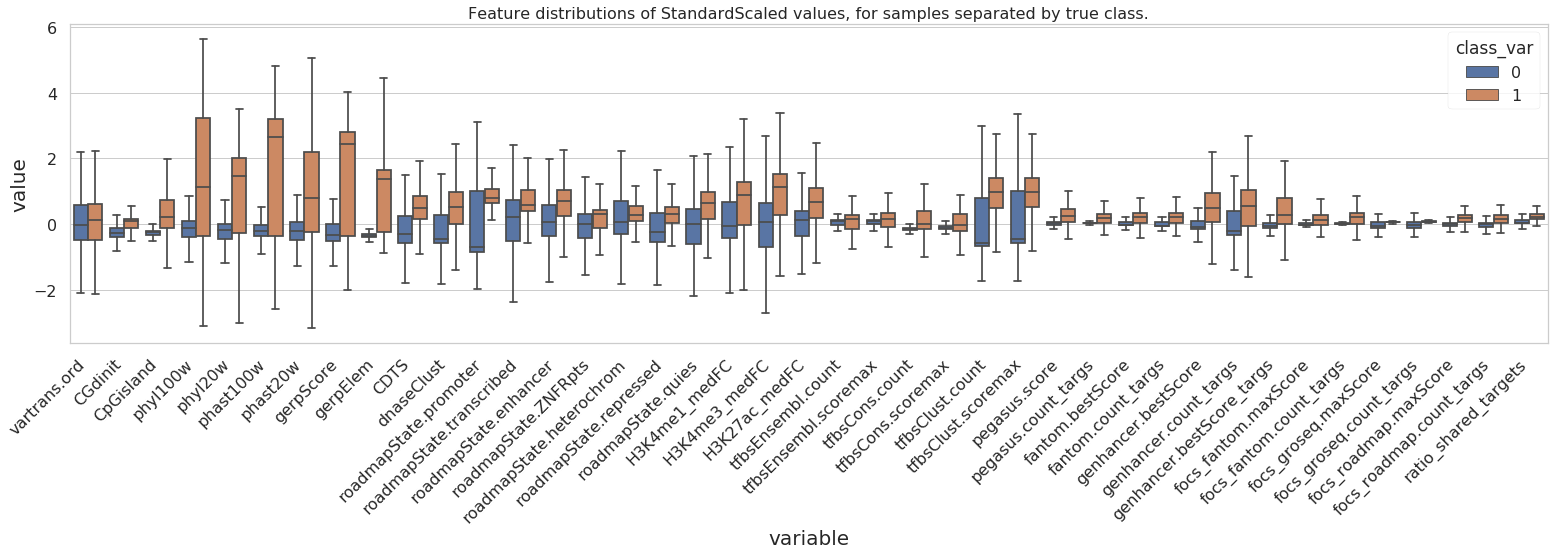

In [35]:
# Boxplot of scaled features
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,1,1)

sns.boxplot(
    data=X_kmeans_scaled.assign(class_var=all_y_arrs['HGMD-DM']['cytobandMatch']
                               ).melt(id_vars=['class_var']),
    x='variable',
    y='value',
    hue='class_var',
    showfliers=False,
    ax=ax1)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax1.set_title("Feature distributions of StandardScaled values, for samples separated by true class.")
plt.show()

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


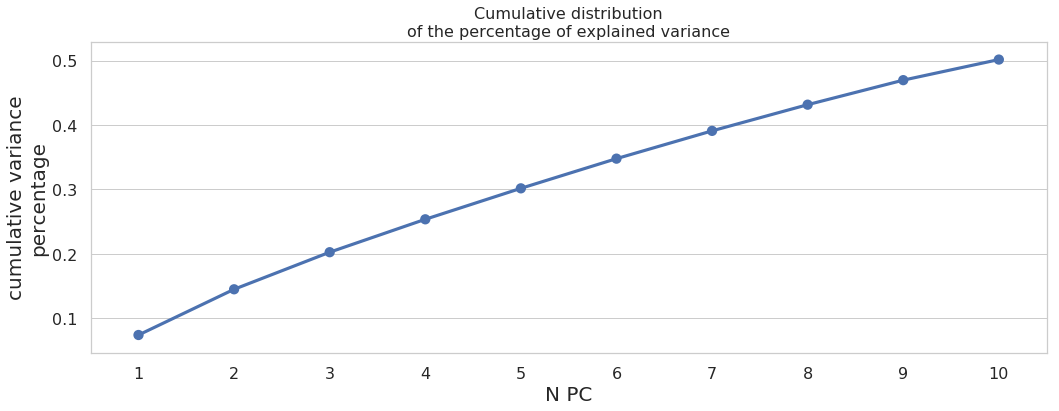

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


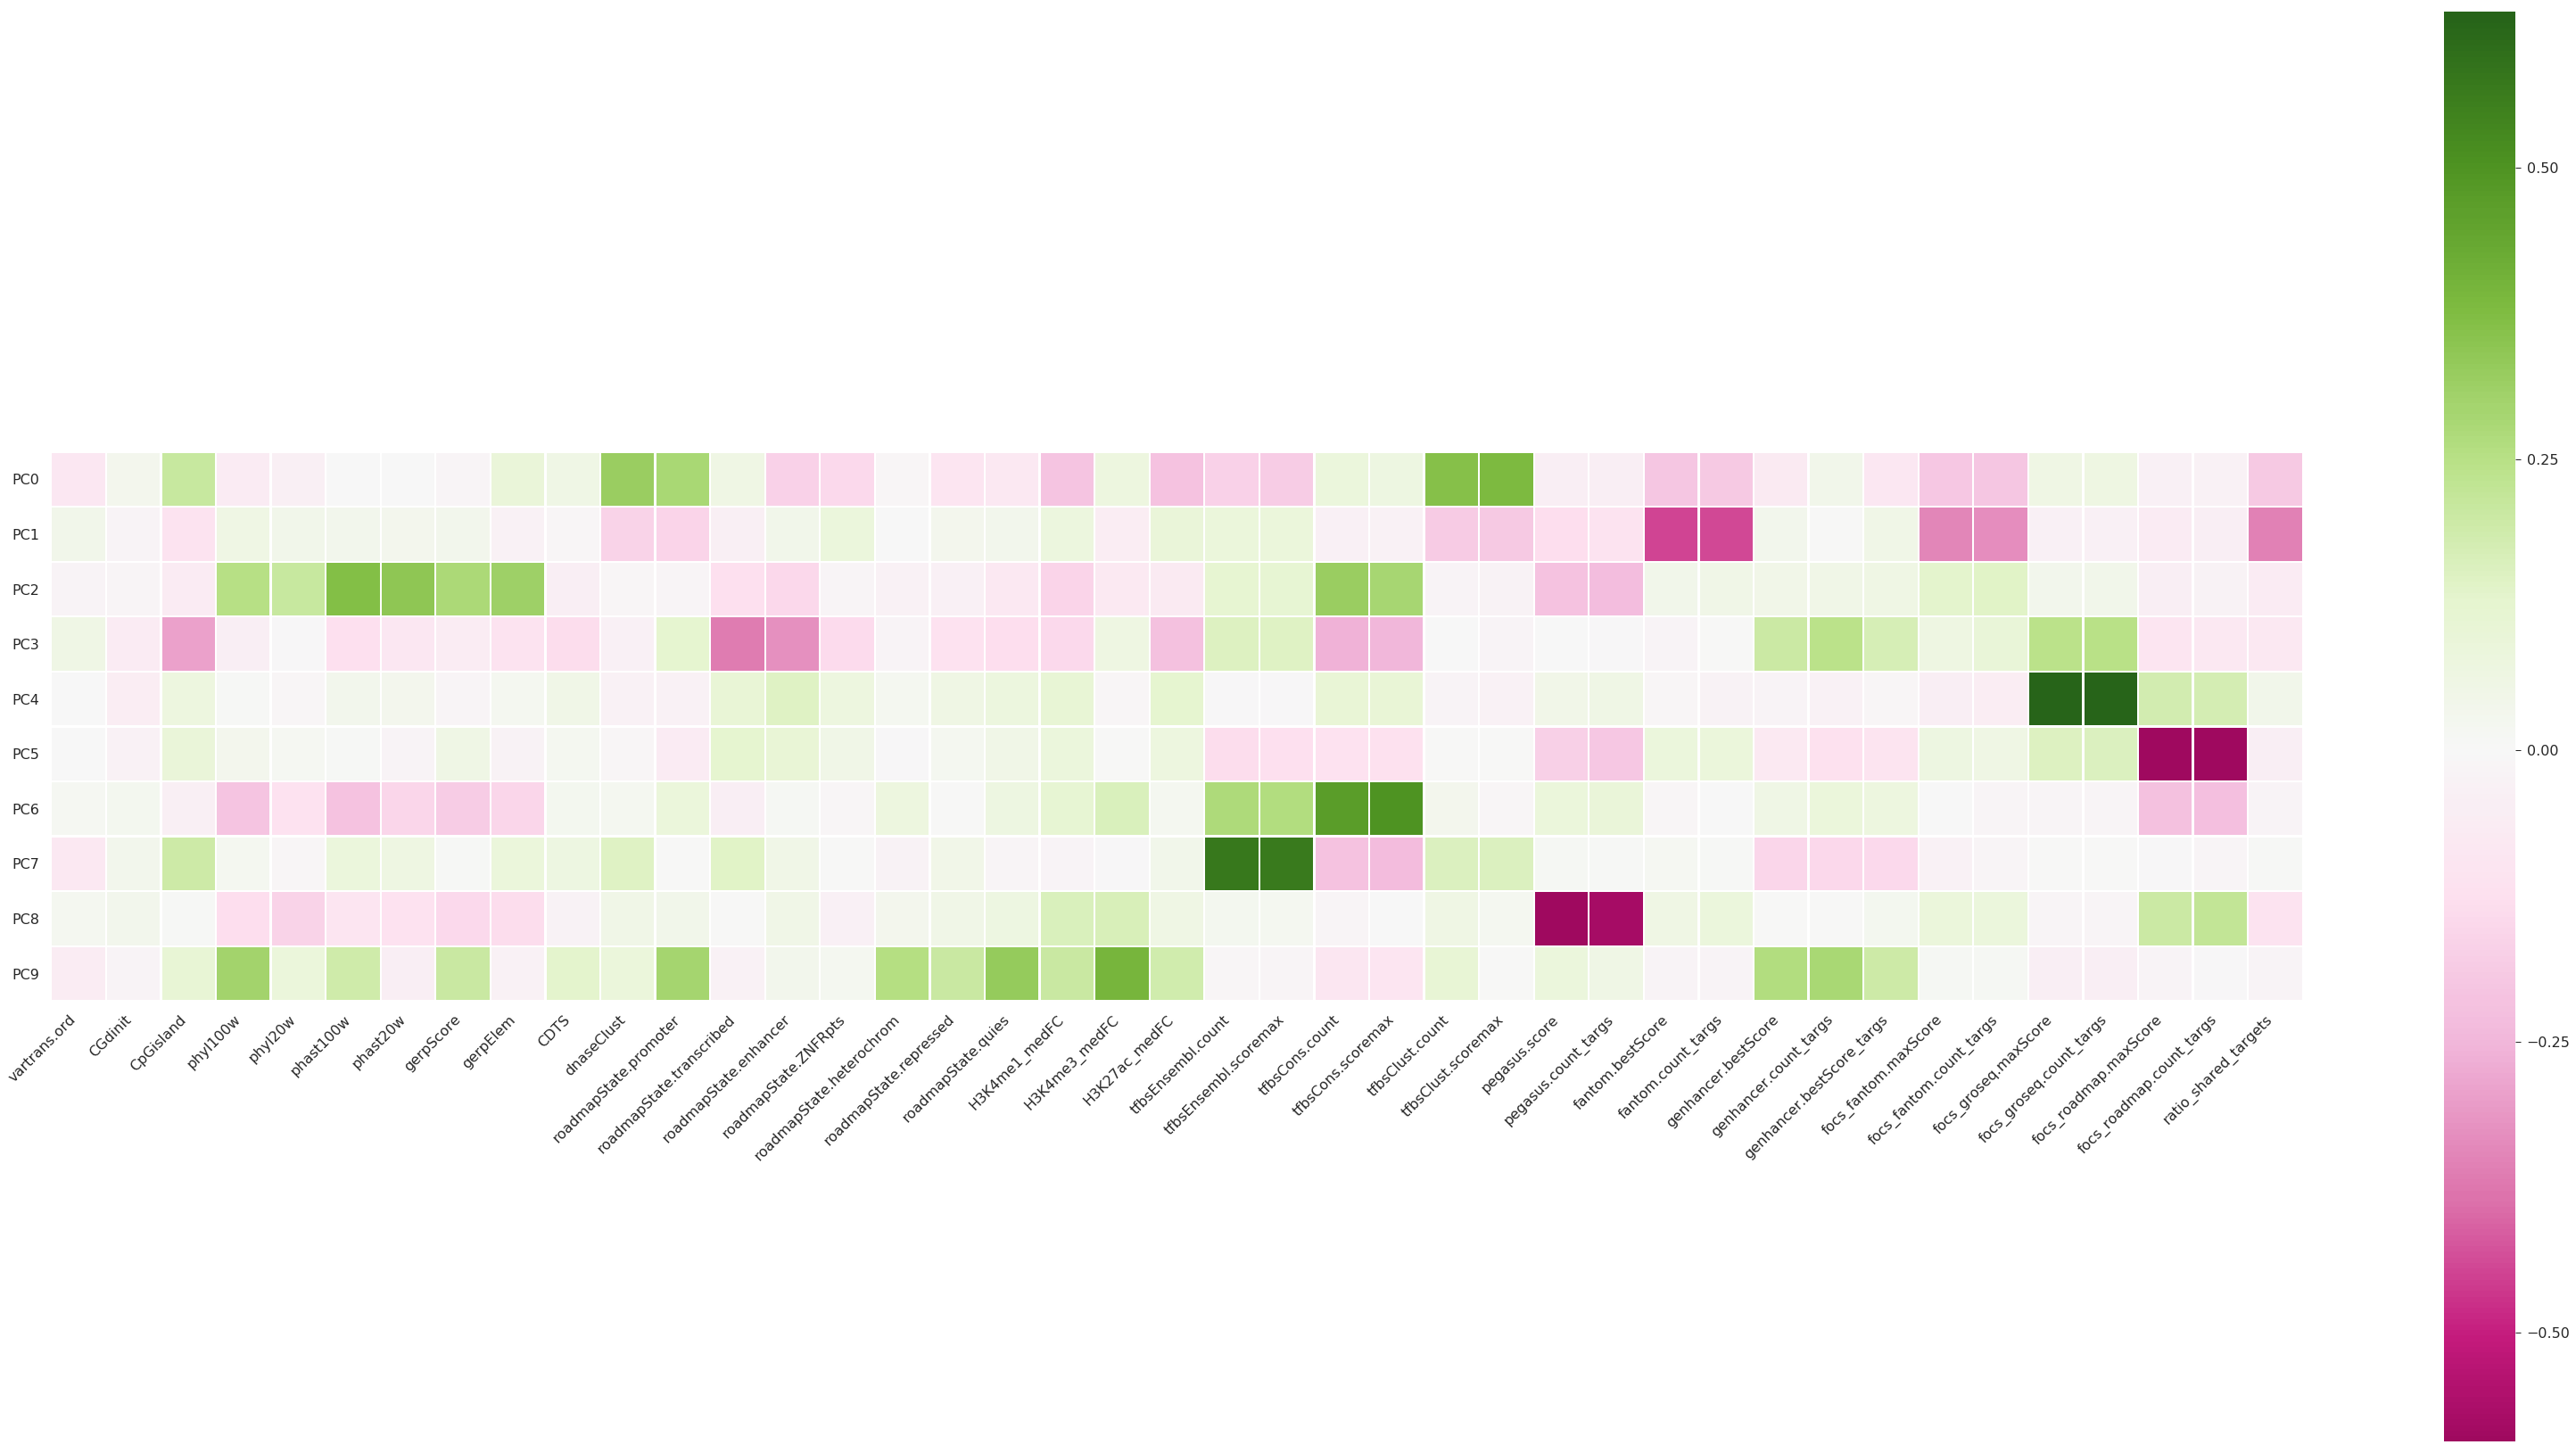

In [36]:
pca_fc = sklearn.decomposition.PCA(n_components=10)
pca_fc.fit(X=X_kmeans_scaled)

ML_PCA.plot_cumulative_variance_pca(pca_fc)

ML_PCA.heatmap_PCA_features_to_PC(pca_fc, X_kmeans_scaled.columns.values, title='')

#### K-means clustering with optimal K

In [37]:
X_trainset = all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,model_columns].loc[sorted(list(interpreter._full_training_indices_set)),:]
y_trainset = all_y_arrs['HGMD-DM']['cytobandMatch'][sorted(list(interpreter._full_training_indices_set))]

In [39]:
kmeans_exploration_results = {}

##### FC profiles normalized, all samples (positive and negatives)

Here : perform a K-means clustering exploration with all variants from the training datasets, basing on their FC profiles.

In [352]:
%%time
# clustering : All samples

n_jobs = 16
max_K = 20
step = 2
N_repeat_silhouette = 5

kmeans_k, inertia, df_silhouettes, labels = feature_contribs_lib.clustering_analysis(
                                                X_kmeans_norm,
                                                n_jobs,
                                                max_K,
                                                step, N_repeat_silhouette)


name_kmeans_exp = 'full_dataset_scaled'
kmeans_exploration_results[name_kmeans_exp] = {}
kmeans_exploration_results[name_kmeans_exp]['kmeans_k'] = kmeans_k
kmeans_exploration_results[name_kmeans_exp]['inertia'] = inertia
kmeans_exploration_results[name_kmeans_exp]['df_silhouettes'] = df_silhouettes
kmeans_exploration_results[name_kmeans_exp]['labels'] = labels

K=2
	Performing K-means: 2019-06-24 22:54:18.357604
	Performing silhouette: 2019-06-24 22:54:20.711719
K=4
	Performing K-means: 2019-06-24 22:57:14.703368
	Performing silhouette: 2019-06-24 22:57:19.956031
K=6
	Performing K-means: 2019-06-24 23:00:09.716261
	Performing silhouette: 2019-06-24 23:00:17.516442
K=8
	Performing K-means: 2019-06-24 23:03:07.846605
	Performing silhouette: 2019-06-24 23:03:21.408257
K=10
	Performing K-means: 2019-06-24 23:06:15.834448
	Performing silhouette: 2019-06-24 23:06:39.632914
K=12
	Performing K-means: 2019-06-24 23:09:27.017354
	Performing silhouette: 2019-06-24 23:09:55.857022
K=14
	Performing K-means: 2019-06-24 23:12:43.087575
	Performing silhouette: 2019-06-24 23:13:24.106581
K=16
	Performing K-means: 2019-06-24 23:16:11.477033
	Performing silhouette: 2019-06-24 23:16:46.989049
K=18
	Performing K-means: 2019-06-24 23:19:32.397773
	Performing silhouette: 2019-06-24 23:20:18.747769
CPU times: user 3min 35s, sys: 23.9 s, total: 3min 59s
Wall time: 28

In [114]:
#copy_kmeans_k, copy_inertia, copy_df_silhouettes, copy_labels = kmeans_k.copy(), inertia.copy(), df_silhouettes.copy(), labels.copy()

##### FC profiles normalized, only correctly assigned samples

Let's also perform the analysis of kmeans clustering only on the samples that are correctly assigned : TP or TN.

For the CytobandMAtch HGMDDM model, the threshold that optimizes for the F1_score is 0.55

In [351]:
%%time
# clustering : only correctly assigned samples

is_correctly_assigned = (feature_contribs_cl1.pred.apply(lambda v: 1 if v>0.55 else 0)==y_trainset).values


n_jobs = 16
max_K = 20
step = 2
N_repeat_silhouette = 5

kmeans_k_TC, inertia_TC, df_silhouettes_TC, labels_TC = feature_contribs_lib.clustering_analysis(
                                                X_kmeans_norm.loc[is_correctly_assigned,:],
                                                n_jobs,
                                                max_K,
                                                step, N_repeat_silhouette)

K=2
	Performing K-means: 2019-06-24 22:29:24.898255
	Performing silhouette: 2019-06-24 22:29:27.165547
K=4
	Performing K-means: 2019-06-24 22:31:59.319733
	Performing silhouette: 2019-06-24 22:32:03.252013
K=6
	Performing K-means: 2019-06-24 22:34:32.421237
	Performing silhouette: 2019-06-24 22:34:42.235441
K=8
	Performing K-means: 2019-06-24 22:37:08.804242
	Performing silhouette: 2019-06-24 22:37:21.892078
K=10
	Performing K-means: 2019-06-24 22:39:48.358617
	Performing silhouette: 2019-06-24 22:40:06.265953
K=12
	Performing K-means: 2019-06-24 22:42:32.290773
	Performing silhouette: 2019-06-24 22:42:54.895772
K=14
	Performing K-means: 2019-06-24 22:45:20.994881
	Performing silhouette: 2019-06-24 22:45:48.530801
K=16
	Performing K-means: 2019-06-24 22:48:15.417963
	Performing silhouette: 2019-06-24 22:48:46.110587
K=18
	Performing K-means: 2019-06-24 22:51:12.129788
	Performing silhouette: 2019-06-24 22:51:46.280070
CPU times: user 2min 52s, sys: 25.6 s, total: 3min 17s
Wall time: 24

##### FC profiles not scaled, False negatives + True positives

Below : performing Clustering on the positive samples only (so FN + TP)

In [42]:
%%time
# clustering : only positive samples (correctly or incorrectly assigned)

n_jobs = 16
max_K = 20
step = 1
N_repeat_silhouette = 5

(kmeans_k,
 inertia,
 df_silhouettes,
 labels) = feature_contribs_lib.clustering_analysis(
                        X_kmeans.loc[y_trainset.astype(bool),:],
                        n_jobs,
                        max_K,
                        step, N_repeat_silhouette)



name_kmeans_exp = 'hgmd_dataset_notscaled'
kmeans_exploration_results[name_kmeans_exp] = {}
kmeans_exploration_results[name_kmeans_exp]['kmeans_k'] = kmeans_k
kmeans_exploration_results[name_kmeans_exp]['inertia'] = inertia
kmeans_exploration_results[name_kmeans_exp]['df_silhouettes'] = df_silhouettes
kmeans_exploration_results[name_kmeans_exp]['labels'] = labels

K=2
	Performing K-means: 2020-05-11 09:42:33.607430
	Performing silhouette: 2020-05-11 09:42:33.700295
K=3
	Performing K-means: 2020-05-11 09:42:34.344410
	Performing silhouette: 2020-05-11 09:42:34.380206
K=4
	Performing K-means: 2020-05-11 09:42:34.803286
	Performing silhouette: 2020-05-11 09:42:34.929625
K=5
	Performing K-means: 2020-05-11 09:42:35.491696
	Performing silhouette: 2020-05-11 09:42:35.531890
K=6
	Performing K-means: 2020-05-11 09:42:35.851571
	Performing silhouette: 2020-05-11 09:42:35.894076
K=7
	Performing K-means: 2020-05-11 09:42:36.128541
	Performing silhouette: 2020-05-11 09:42:36.222863
K=8
	Performing K-means: 2020-05-11 09:42:36.492765
	Performing silhouette: 2020-05-11 09:42:36.890285
K=9
	Performing K-means: 2020-05-11 09:42:37.316345
	Performing silhouette: 2020-05-11 09:42:37.535360
K=10
	Performing K-means: 2020-05-11 09:42:37.795986
	Performing silhouette: 2020-05-11 09:42:37.944635
K=11
	Performing K-means: 2020-05-11 09:42:38.122331
	Performing silhoue

#### Visualization of optimal K search

In [46]:
optimal_thresholds = {}
optimal_thresholds['HGMDDM_cytoband'] = 0.51

In [47]:
name_kmeans_exp = 'hgmd_dataset_notscaled'

kmeans_k = kmeans_exploration_results[name_kmeans_exp]['kmeans_k']
inertia = kmeans_exploration_results[name_kmeans_exp]['inertia']
df_silhouettes = kmeans_exploration_results[name_kmeans_exp]['df_silhouettes'] = df_silhouettes
labels = kmeans_exploration_results[name_kmeans_exp]['labels']

In [55]:
# Here : gather in a single dataframe all quality measures associated to the cluster labels for the list of K explored clusters
df_clusters_measures = feature_contribs_lib.clustering_analysis_measures(
                                 X_trainset.assign(
                                     true_class=y_trainset,
                                     predicted_class=feature_contribs_cl1['pred']>optimal_thresholds['HGMDDM_cytoband']
                                     ).loc[y_trainset.astype(bool),:],
                                 kmeans_k,
                                 inertia,
                                 df_silhouettes,
                                 labels)

display(df_clusters_measures.head(3))

,silhouette,silhouette,silhouette,silhouette,silhouette,inertia,mean_accuracy,mean_classCluster_accuracy
2,0.370136,0.370136,0.370136,0.370136,0.370136,17.520214,0.772286,1.000000
3,0.380622,0.380622,0.380622,0.380622,0.380622,14.873300,0.628685,0.857631
4,0.356685,0.356685,0.356685,0.356685,0.356685,13.495198,0.662992,0.872437


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


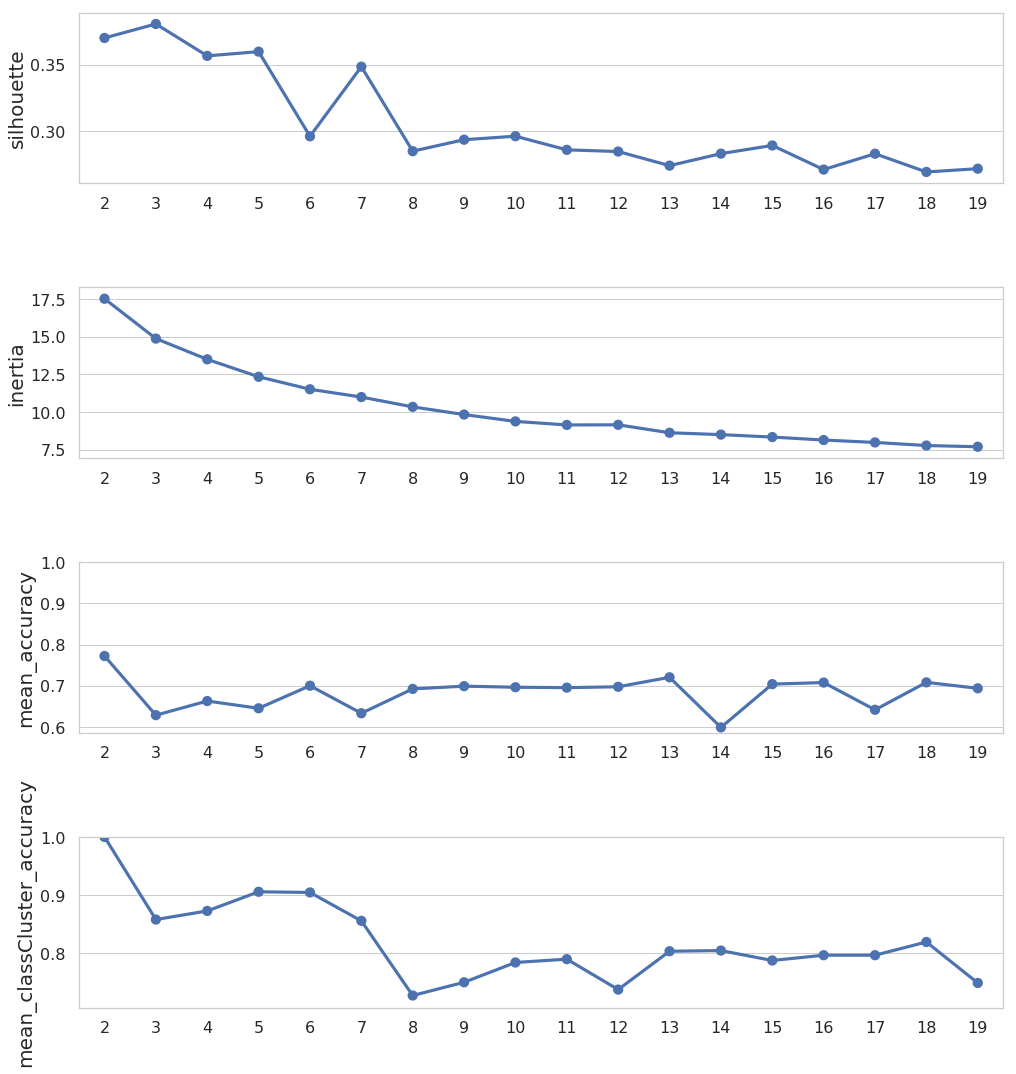

In [56]:
# Plot the different measures and export the plot
feature_contribs_lib.plot_clustering_measures(df_clusters_measures,
                                              savefig_file=path_results_feat_contribs+'/k-means_clustering_K_exploration_quality-scores.svg')

In [59]:
# Export the table with the quality measures at eack K.
df_clusters_measures.to_csv(
    path_results_feat_contribs+"/k-means_clustering_K_exploration_quality-measures.tsv.gz",
    header=True,
    index=True,
    sep="\t",compression="gzip")

In [54]:
# Gather in a single table the label assignment of samples for each K explored.
df_clustering_label_assignments_per_K = pd.DataFrame(dict(zip(kmeans_k, labels))
                                                   )
display(df_clustering_label_assignments_per_K.head(3))
df_clustering_label_assignments_per_K.to_csv(
    path_results_feat_contribs+"/k-means_clustering_K_exploration_assigned-clusters_positive-samples.tsv.gz",
    header=True,
    index=False,
    sep="\t",
    compression="gzip")

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,2,0,3,1,1,7,4,5,2,4,4,1,9,16,13,12
1,1,0,2,0,3,1,1,7,4,5,2,4,4,1,9,16,13,12
2,0,1,1,1,1,0,0,8,1,7,9,11,11,9,2,5,8,4


### Selected clusters exploration

In [58]:
df_clustering_label_assignments_per_K = pd.read_table(path_results_feat_contribs+"/k-means_clustering_K_exploration_assigned-clusters_positive-samples.tsv.gz")
labels = [df_clustering_label_assignments_per_K[c].values for c in df_clustering_label_assignments_per_K.columns]

In [67]:
index_selected_clusters = 5
N_selected_clusters = np.unique(df_clustering_label_assignments_per_K.iloc[:,index_selected_clusters]).shape[0]

print("Number of clusters at the selected index: {}".format(N_selected_clusters))

Number of clusters at the selected index: 7


In [68]:
selected_labels_training = df_clustering_label_assignments_per_K.iloc[:,index_selected_clusters].values
uniq_selected_labels = sorted(np.unique(selected_labels_training))
set_selected_labels = ["{}".format(v) for v in uniq_selected_labels]

list_bool_selected_clusters = [np.array([True if label==cluster else False for label in selected_labels_training]) for cluster in uniq_selected_labels]

#### TP /FN composition of clusters

In [69]:
def pred_cat(row):
    if row['predicted_class'] == 1:
        if row['true_class']==1:
            return "true_pos"
        else:
            return "false_pos"
    else:
        if row.loc['true_class']==0:
            return "true_neg"
        else:
            return "false_neg"

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains c

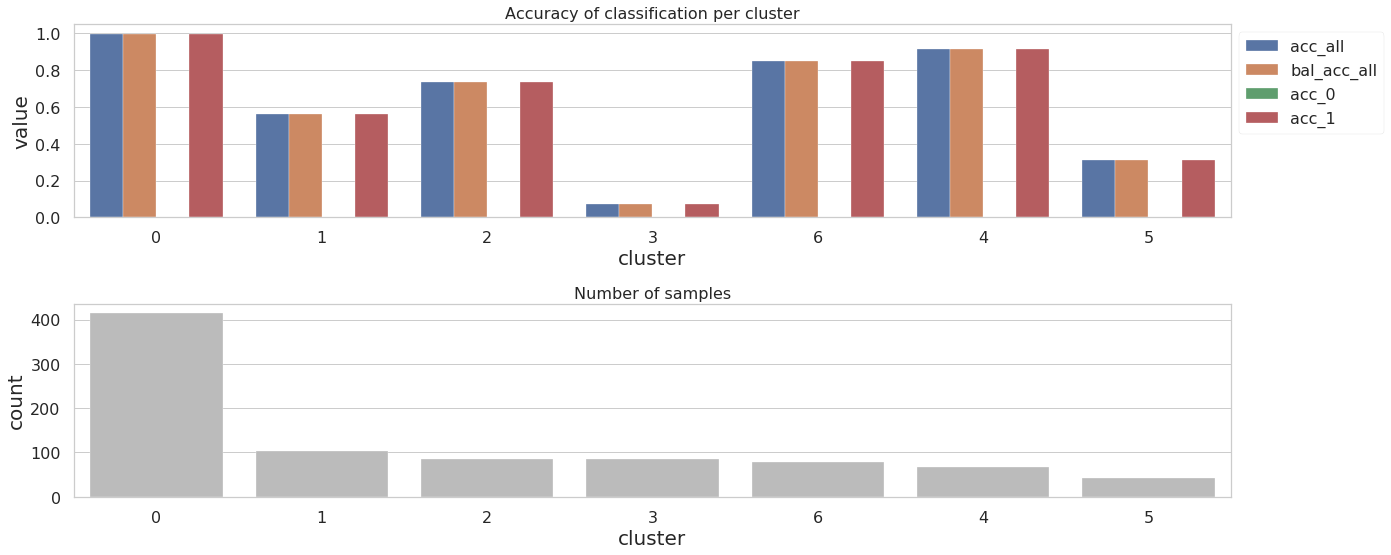

In [78]:
# First try for a representation of cluster composition in terms of TP, TN, FP, FN.
(selected_labels,
 set_selected_labels,
 list_bool_selected_clusters,
 res_acc) = feature_contribs_lib.select_labels_cluster_analysis(
                N_selected_clusters,
                labels,
                X_trainset.assign(
                    true_class=y_trainset,
                    predicted_class=(feature_contribs_cl1['pred']>optimal_thresholds['HGMDDM_cytoband']).astype(int)
                ).loc[y_trainset.astype(bool),:]
             )

ML_visualization.plot_accuracy_clusters(res_acc, selected_labels, set_selected_labels)

In [79]:
# Here : build tables to associate clusters to metrics about correct labelling.

# Before computing the tables : create a table associating true class, predicted class, and assigned cluster, to all variants
clusters_to_positive_counts = X_trainset.assign(
                                            true_class=y_trainset,
                                            predicted_class=(feature_contribs_cl1['pred']>optimal_thresholds['HGMDDM_cytoband']).astype(int)
                                            ).loc[y_trainset.astype(bool),
                                                  ['true_class','predicted_class']
                                                 ].assign(clust=[int(v) for v in labels[index_selected_clusters]]
                                                         )

# First table gathers percentages for TP and FN in the different clusters.
clusters_to_positive_perc = clusters_to_positive_counts.groupby('clust').apply(lambda g: pd.Series({
                                                  'perc_FN':g.loc[g['true_class']!=g['predicted_class'],:].shape[0]/g.shape[0]*100,
                                                  'perc_TP':g.loc[g['true_class']==g['predicted_class'],:].shape[0]/g.shape[0]*100})
                                                                              ).reset_index()

# and now the second table with counts for TP and FN is built.
clusters_to_positive_counts = clusters_to_positive_counts.groupby('clust').apply(lambda g: pd.Series({
                                                  'total_FN':g.loc[g['true_class']!=g['predicted_class'],:].shape[0],
                                                  'total':g.shape[0],
                                                  'total_TP':g.loc[g['true_class']==g['predicted_class'],:].shape[0]
                                                 })).reset_index()


# Here : ordering of clusters by both their proportion of TP, and their size.
ordered_clusters = [str(v) for v in clusters_to_positive_counts.assign(
                                proportion_TP=lambda df: df['total_TP']/df['total']
                                ).sort_values(by=['proportion_TP','total'],
                                              ascending=False)['clust'].values]


# EXPORT
clusters_to_positive_counts.to_csv(path_results_feat_contribs+"/k-means_K={}_size-and-TP-FN_composition.tsv".format(N_selected_clusters),
                                   header=True, index=False, sep="\t")
clusters_to_positive_perc.to_csv(path_results_feat_contribs+"/k-means_K={}_percentage-TP-FN_composition.tsv".format(N_selected_clusters),
                                 header=True, index=False, sep="\t")

In [93]:
print(path_results_feat_contribs+"/k-means_K={}_size-and-TP-FN_composition.tsv".format(N_selected_clusters),)
print(path_results_feat_contribs+"/k-means_K={}_percentage-TP-FN_composition.tsv".format(N_selected_clusters))

/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11//k-means_K=7_size-and-TP-FN_composition.tsv
/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11//k-means_K=7_percentage-TP-FN_composition.tsv


In [91]:
display(clusters_to_positive_counts)
display(clusters_to_positive_perc)

,clust,total_FN,total,total_TP
0,0,1,415,414
1,1,45,103,58
2,2,23,86,63
3,3,79,85,6
4,4,6,68,62
5,5,29,42,13
6,6,12,79,67


,clust,perc_FN,perc_TP
0,0,0.240964,99.759036
1,1,43.689320,56.310680
2,2,26.744186,73.255814
3,3,92.941176,7.058824
4,4,8.823529,91.176471
5,5,69.047619,30.952381
6,6,15.189873,84.810127


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


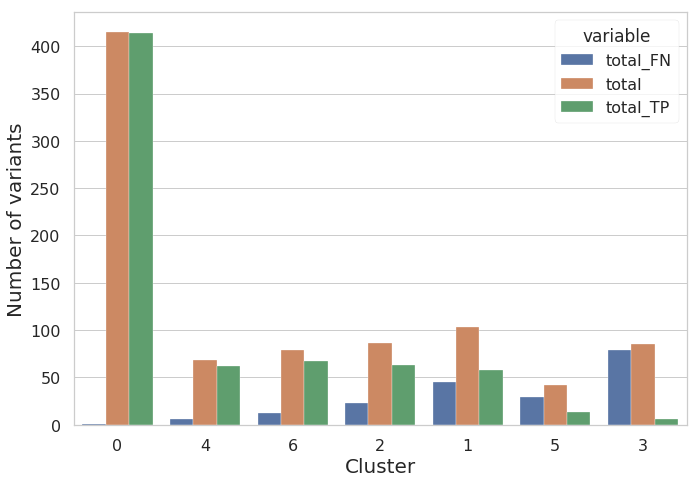

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


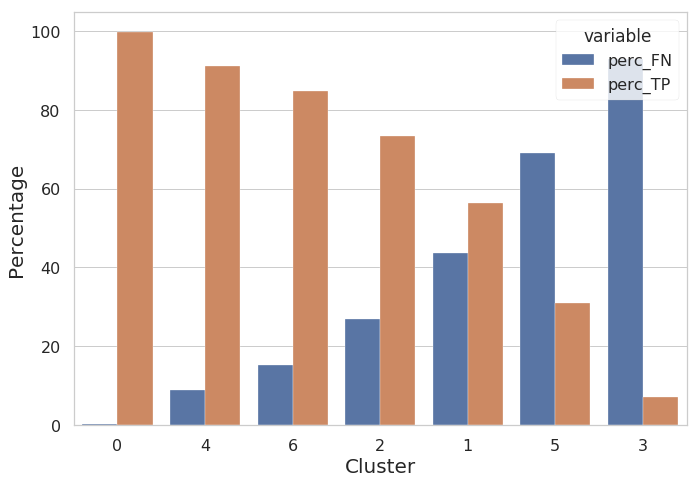

In [80]:
# Below : plots of the tables of percentage/counts of TP and FN.


# Plot the counts of TP/TN per cluster
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(data=clusters_to_positive_counts.assign(clust=lambda df: df['clust'].astype(str)).melt(id_vars=['clust']),
            x='clust',
            order=ordered_clusters,
            y='value',
            hue='variable',
            ax=ax1
           )

ax1.set_ylabel('Number of variants')
ax1.set_xlabel('Cluster')

plt.savefig(path_results_feat_contribs+'/k-means_K={}_size-and-TP-TN_composition.svg'.format(N_selected_clusters))
plt.show()


# Plot the percentage of TP per cluster
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(data=clusters_to_positive_perc.assign(clust=lambda df: df['clust'].astype(str)).melt(id_vars=['clust']),
            x='clust',
            order=ordered_clusters,
            y='value',
            hue='variable',
            ax=ax1
           )

ax1.set_ylabel('Percentage')
ax1.set_xlabel('Cluster')

plt.savefig(path_results_feat_contribs+'/k-means_K={}_size-and-TP-TN_composition_PERCENTAGE.svg'.format(N_selected_clusters))
plt.show()

In [92]:
print(path_results_feat_contribs+'/k-means_K={}_size-and-TP-TN_composition.svg'.format(N_selected_clusters))
print(path_results_feat_contribs+'/k-means_K={}_size-and-TP-TN_composition_PERCENTAGE.svg'.format(N_selected_clusters))

/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11//k-means_K=7_size-and-TP-TN_composition.svg
/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11//k-means_K=7_size-and-TP-TN_composition_PERCENTAGE.svg


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


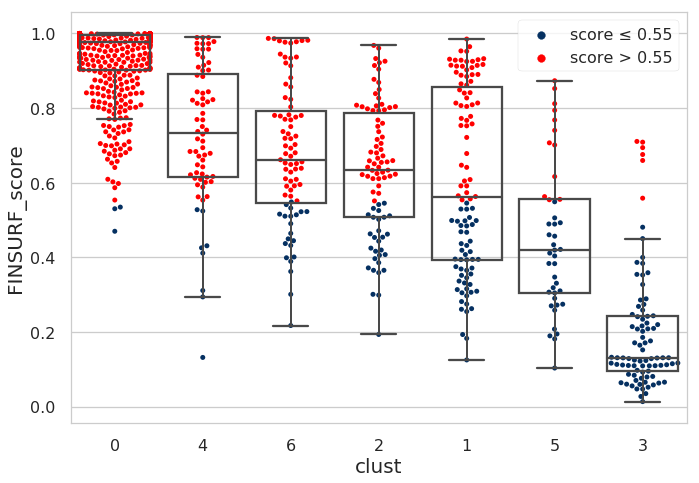

In [405]:
tmp_scores_per_cluster = X_trainset.assign(true_class=y_trainset,
                                          predicted_class=(feature_contribs_cl1['pred']>optimal_thresholds['HGMDDM_cytoband']).astype(int),
                                          FINSURF_score=(feature_contribs_cl1['pred']),
                                          ).loc[y_trainset.astype(bool),['FINSURF_score','predicted_class']
                                               ].assign(clust=[str(v) for v in labels_P_noscaled[index_selected_clusters]]
                                                       )


palette_cluster_tmp = {1:'#FF0000',0:'#053061'}
fig = plt.figure(figsize=(10,7))

ax1 = sns.swarmplot(data=tmp_scores_per_cluster,
                    x='clust',
                    y='FINSURF_score',
                    hue='predicted_class',
                    order=ordered_clusters,
                    palette=palette_cluster_tmp,
                    zorder=1
                     )

sns.boxplot(x="clust", y="FINSURF_score",
            data=tmp_scores_per_cluster, 
            order=ordered_clusters,
            showcaps=True,
            boxprops={'facecolor':'None', "zorder":10},
            showfliers=False,
            whiskerprops={'linewidth':2, "zorder":10},
            ax=ax1, zorder=10)

legend = ax1.legend(bbox_to_anchor=(1,1))

tmp_rename_legend_handles = {'0':'score ≤ {}'.format(optimal_thresholds['HGMDDM_cytoband']),
                             '1':'score > {}'.format(optimal_thresholds['HGMDDM_cytoband'])
                            }
                             

for legend_handles_label in legend.get_texts():
    text = legend_handles_label.get_text()
    legend_handles_label.set_text(tmp_rename_legend_handles[text])
    
    
plt.savefig(path_results_feat_contribs+'/k-means_K={}_FINSURFscore-distribs.svg'.format(N_selected_clusters))
plt.show()

This plot below needs to be improved :
- we don't know the number of elements per true y-class per cluster.
- ugly representation

/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


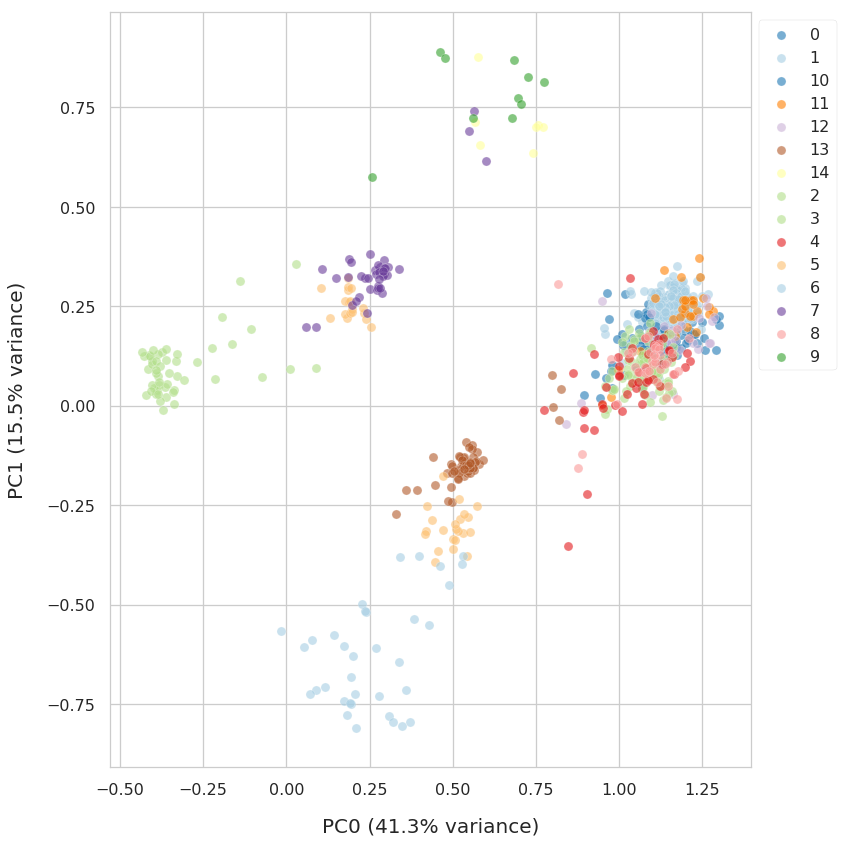

In [782]:
# plot samples on PC axes.
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,1,1)

ML_PCA.plot_samples_PCA_2d(pca_fc, X_kmeans_norm.loc[y_trainset.astype(bool),:], labels=selected_labels,
                           #colors_labels=clusters_colors,
                           ax=ax1,
                           show_plot=True,
                          )#savefig_file="/users/ldog/moyon/Thesis/writting/FINSURF_ARTICLE/00_pre-submission/02_figures/figure_interpreting_classification/panel_PCA_feature_contribs.svg")

# ax2 = fig.add_subplot(1,2,2, projection='3d')
# ML_PCA.plot_samples_PCA_3d(pca_fc, X_kmeans_norm, labels=selected_labels, colors_labels=clusters_colors,ax=ax2, show_plot=True)

#### Heatmap of mean feature contributions per cluster

In this block and the following blocks of codes rely on two important functions from my lib.

Their code is printed below.

- `summarize_annotations_per_group` will group variants in a dataframe acording to a given bolean vector. For each group, each feature is summarized to a single value from all the variants' values, depending on the column type (for binary : calculate proportions ; for continuous/discrete : calculate mean, after 1-99 quantile robust-scaling if `normalize` is True).<hr>
- `multiple_relative_changes` applies systematically the `summarize_annotations_per_group` function to a list of dataframes using a list of boolean vectors. This allows me to speed the comparison of each cluster against the rest of the dataset. For each dataframe in the list:
    - summarized values per group are calculated
    - a relative-change vector is calculated (measuring the effect-size between the "selected" variants - bool=1 - and the "others" variants.) 
    - P-values are also calculated between groups of each dataframe. These can be corrected for each dataframe (independant_corrections=True), or after all dataframes have been processed (independant_corrections=False) using the "Holm Bongerroni adjustments".

In [178]:
print(inspect.getsource(ML_tests.summarize_annotations_per_group))
print(inspect.getsource(ML_tests.multiple_relative_changes))

def summarize_annotations_per_group(X, bool_selected, cols_type, normalize=False):
    """ Return a dataframe of shape N_feature x 2, with summarized values per category.
    
    For each feature in X (which should have an associated column type in <cols_type>),
    samples are separated according to <bool_selected>, a summarizing operation is applied.
    
    For binary: return the ratio of samples with the annotation.
    For discrete / continuous: return the mean.
    
    To be noted that it is possible to summarize the full dataframe without selected any samples,
    by providing an array of True for all samples as <bool_selected>.
    
    In:
        X (pandas.DataFrame): dataframe of N_samples x N_features, with features to summarize.
        bool_selected (pandas.Series): boolean array used to separate samples.
        cols_type (dict): map column types (binary, discrete, continuous) to list of features
        normalize ([bool, default=False]): robust scaling (1perc ignored

In [331]:
%%time

# HERE : comparison of Feature Contributions for variants in each clusters against variants in OTHER clusters.
# Use directly feature contributions, rather than normalized feature contributions.

list_Xclust_FC =  itt.repeat(X_kmeans.loc[y_trainset.astype(bool),:], len(set_selected_labels))


itt.repeat(X_trainset_positives_and_others.loc[y_trainset.astype(bool),:],
                                       len(set_selected_labels))


(contribs_clusters,
 contribs_relative_changes_clusters,
 contribs_pvals_df_clusters) = ML_tests.multiple_relative_changes(
                                    list_Xclust_FC,
                                    list_bool_selected_clusters,
                                    cols_type={c:'continuous' for c in X_kmeans.columns.values}
                                    )

# Create long format of this dataframe
long_merged_contribs_clusters = pd.concat([ctb_df.reset_index().melt(id_vars='index').assign(cluster=label)
                                           for ctb_df,label in zip(contribs_clusters,set_selected_labels)]
                                        ).reset_index(drop=True).set_axis(['feature','sample_set','value','cluster'],
                                                                           axis=1,
                                                                           inplace=False)                 

CPU times: user 836 ms, sys: 28 ms, total: 864 ms
Wall time: 1.05 s


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


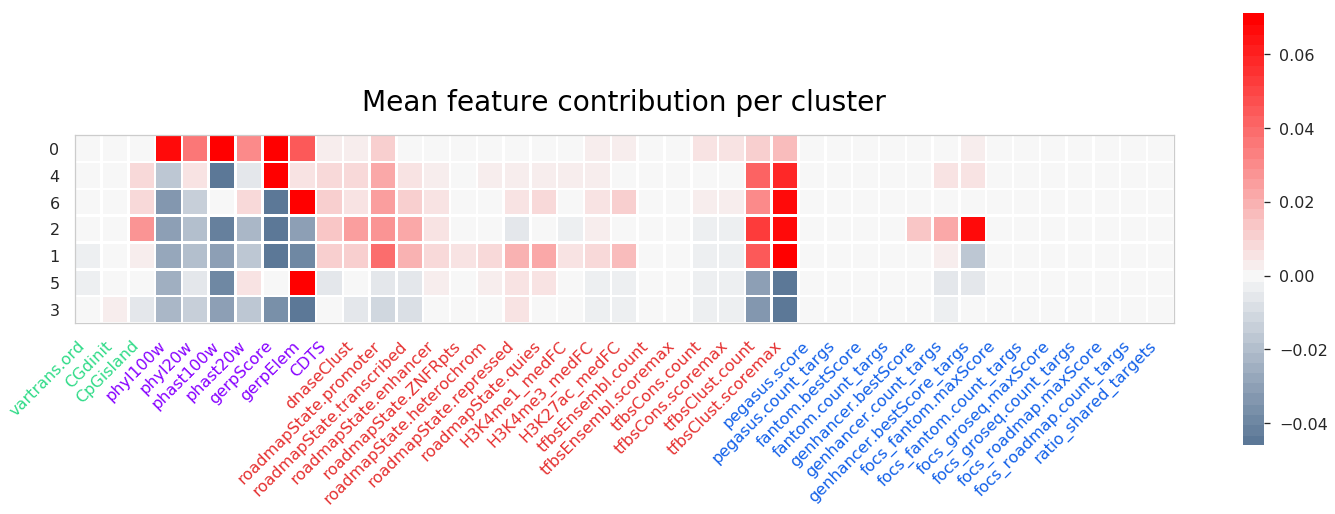

In [332]:
# Feature contributions mean value per cluster


# Here : for each dataframe of summarized contributions per cluster, get the values associated to the "selected" variants,
# ie the ones which are in the considered cluster.
zipped_cluster_contribs = zip([ctb_df.loc[model_columns,'selected'] for ctb_df in contribs_clusters],
                               set_selected_labels)

# Sort this list of (contribs-vector, cluster_name) by the cluster_name according to the `ordered_clusters` list.
ordered_cluster_contribs = sorted(zipped_cluster_contribs, key=lambda v: ordered_clusters.index(v[1]))


# And visualize into a heatmap the 
ML_visualization.heatmap_relative_changes(
     [ctbVectAndClustIdx[0] for ctbVectAndClustIdx in ordered_cluster_contribs],
     heatmap_columns = ordered_clusters,
     list_pvals_df=None,
     mask_nonsign=False,
     my_cmap = cmap_HGMD,
     feature_colors=feature_colors,
     title="Mean feature contribution per cluster",
     title_color='#000000',
     savefig_file=path_results_feat_contribs+"k-means_K={}_heatmap_mean-feature-contribs.svg".format(N_selected_clusters),
     show_plot=True
    )

#### Heatmap of normalized feature values differences

In [333]:
# Here : "normalize" feature raw values of samples from the training set.
# See the `build_mapper_features_preprocessing` for details on the normalizing procedure per feature type (binary, continuous, discrete)

mapper = build_mapper_features_preprocessing(cat_features, X_trainset, model_columns)

X_trainset_positives_and_others = mapper.fit_transform(pd.concat([X_trainset.loc[y_trainset.astype(bool),model_columns],
                                                                  X_trainset.loc[~y_trainset.astype(bool),model_columns]])
                                                      )

Columns without assigned Impute strategy (will be lost if no strategy set):


[]

In [334]:
%%time

# HERE : comparison of (normalized) feature values for variants in each clusters against `COMPARISON_TYPE` variants.
#
# The use of the "FULL_DATASET" `COMPARISON_TYPE` allows to highlight the distinction between positive variants and negative variants,
# rather than between positive variants of different clusters.
#
# In this second case (COMPARISON_TYPE=="CLUSTERS"), variants that are of low conservation for instance will appear as
# extremely poorly conserved ; while the comparison with the full dataset allows to smooth this difference, as many negative variants
# are less conserved.


#COMPARISON_TYPE = "OTHER CLUSTERS"
COMPARISON_TYPE = "FULL_DATASET"


if COMPARISON_TYPE == "FULL_DATASET":
    
    list_Xclust_featNorm = itt.repeat(X_trainset_positives_and_others,
                                      len(set_selected_labels))

    # here : we merge each list of bool values (matching only Positive Samples) with a list of FALSE values for negative variants.
    list_bool_clusterVariants_vs_restDataset = []
    
    for l_bool in list_bool_selected_clusters:
        # We will concatenate the current l_bool (separating variants of the cluster from variants of other clusters)
        # with a list of "False" bool values for negative variants, which size is calculated from the y_trainset vector.
        negatives_l_bool = [False for v in range((~y_trainset.astype(bool)).sum())]
        tmp_l_bool = np.concatenate([l_bool, negatives_l_bool])
        list_bool_clusterVariants_vs_restDataset.append(tmp_l_bool)

    
    (summarized_clusters,
     relative_changes_clusters,
     pvals_df_clusters) = ML_tests.multiple_relative_changes(
                              list_Xclust_featNorm,
                              list_bool_clusterVariants_vs_restDataset,
                              col_types)
    
elif COMPARISON_TYPE == "OTHER CLUSTERS":

    list_Xclust_featNorm =  itt.repeat(X_trainset_positives_and_others.loc[y_trainset.astype(bool),:],
                                       len(set_selected_labels))
    
    # Below : legacy code for normalizing features only among positive variants.
    # list_Xclust_featNorm = itt.repeat(mapper.fit_transform(X_trainset.loc[y_trainset.astype(bool),model_columns]),
    #                                  len(set_selected_labels))
        
    (summarized_clusters,
     relative_changes_clusters,
     pvals_df_clusters) = ML_tests.multiple_relative_changes(
                              list_Xclust_featNorm,
                              list_bool_selected_clusters,
                              col_types)

# Create long format of this dataframe
long_merged_features_clusters = pd.concat([summarized_df.reset_index().melt(id_vars='index').assign(cluster=label)
                                           for summarized_df,label in zip(summarized_clusters, set_selected_labels)]
                                         ).reset_index(drop=True).set_axis(['feature','sample_set','value','cluster'],
                                                                           axis=1,
                                                                           inplace=False)               

CPU times: user 1min 44s, sys: 5.1 s, total: 1min 49s
Wall time: 4.75 s


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


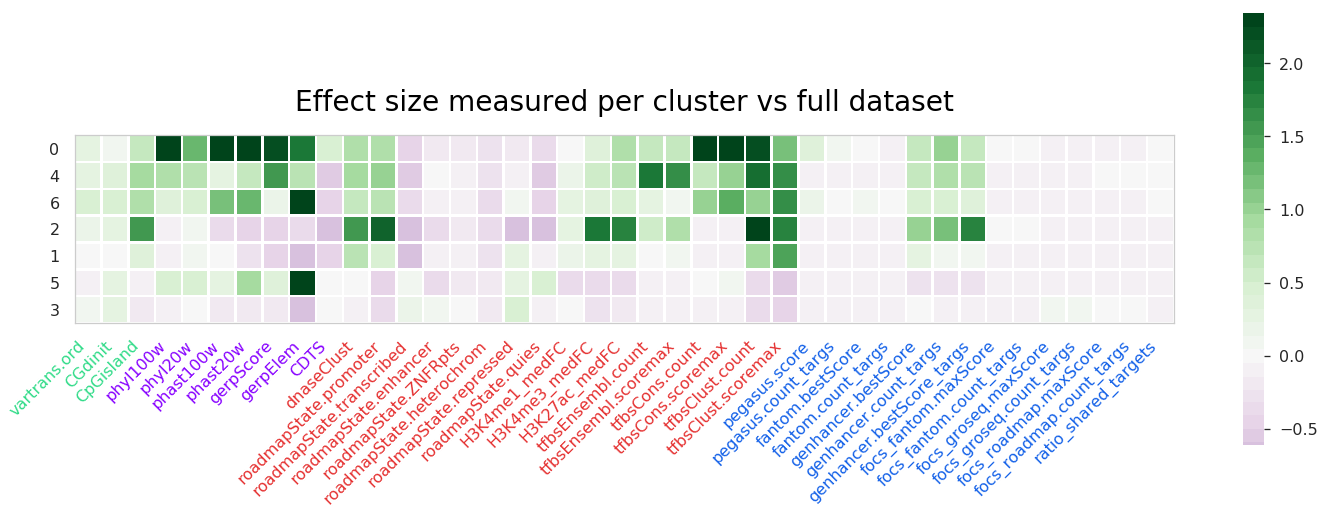

In [335]:
# Here we plot the relative change / effect size for variants in each cluster
# vs the variants from the reference set (other clusters or rest of training dataset).


zipped_cluster_relch = zip([relch_cl.loc[model_columns] for relch_cl in relative_changes_clusters], set_selected_labels)
ordered_cluster_relch = sorted(zipped_cluster_relch, key=lambda v: ordered_clusters.index(v[1]))

zipped_clusters_pvals = zip(pvals_df_clusters, set_selected_labels)
ordered_clusters_pvals = sorted(zipped_clusters_pvals, key=lambda v: ordered_clusters.index(v[1]))


ML_visualization.heatmap_relative_changes([u[0] for u in ordered_cluster_relch],
                                         ordered_clusters,
                                         [pval_df_tuple[0] for pval_df_tuple in ordered_clusters_pvals], 
                                         mask_nonsign=False,
                                         feature_colors=feature_colors,
                                         my_cmap=cmap_enrichment,
                                         title="Effect size measured per cluster vs {}".format(COMPARISON_TYPE.lower().replace('_',' ')),
                                         title_color='#000000',
                                         savefig_file=path_results_feat_contribs+"k-means_K={}_heatmap_effect-sizes_VS-{}.svg".format(N_selected_clusters,
                                                                                                                                      COMPARISON_TYPE),
                                         show_plot=True
                                         )

#### Combined plots : FC vs normalized FV

In [336]:
# Here we recalculate the relative changes, with normalized features.
# This will be used to represent on a barplot all features, with a shared y_axis.
# Note: the relative ratios are impacted (denominator has a `+ abs(mu)`, which reduces the ratio.)


# Here : for each cluster, we combine the positive variants from OTHER clusters with NEGATIVE variants.
# So that the summary for a given cluster can be compared against the REST of the training dataset,
# and not just the other clusters of positives.

list_bool_clusterVariants_vs_restDataset = []
for l_bool in list_bool_selected_clusters:
    # We will concatenate the current l_bool (separating variants of the cluster from variants of other clusters)
    # with a list of "False" bool values for negative variants, which size is calculated from the y_trainset vector.
    negatives_l_bool = [False for v in range((~y_trainset.astype(bool)).sum())]
    tmp_l_bool = np.concatenate([l_bool, negatives_l_bool])
    list_bool_clusterVariants_vs_restDataset.append(tmp_l_bool)
                                             
# relative changes of feature values
(summarized_clusters_norm,
 relative_changes_clusters_norm,
 pvals_df_clusters_norm) = ML_tests.multiple_relative_changes(
                                itt.repeat(X_trainset_positives_and_others, len(set_selected_labels)),
                                list_bool_clusterVariants_vs_restDataset,
                                normalize="strong",
                                cols_type=col_types)

# Create long format of this dataframe
long_merged_features_clusters_norm = pd.concat([summarized_df.reset_index().melt(id_vars='index').assign(cluster=label)
                                           for summarized_df,label in zip(summarized_clusters_norm, set_selected_labels)]
                                         ).reset_index(drop=True).set_axis(['feature','sample_set','value','cluster'],
                                                                           axis=1,
                                                                           inplace=False)               

##### DEMO

In this part I am showing the code to obtain the different objects and tables that are needed to plot the feature contributions + raw feature values of variants in a given cluster.

In [203]:
print(inspect.getsource(ML_visualization.get_data_from_cluster))

def get_data_from_cluster(k_clust,
                      list_relative_changes_clusters,
                      list_pvals_df_clusters,
                      long_merged_contribs_clusters,
                      long_merged_features_clusters,
                      X,
                      labels):
    
    # Feature summarized values
    relative_changes_cluster = list_relative_changes_clusters[k_clust]
    dict_feature_pvals = list_pvals_df_clusters[k_clust].set_index('feature')['pval_label'].to_dict()
    
    
    # This table has N_feature x N_cluster contribution values.
    merged_contribs_clusters_selected = long_merged_contribs_clusters.loc[
                                            long_merged_contribs_clusters['sample_set']=='selected',
                                            :].pivot(columns='cluster',
                                                     index='feature',
                                                     values='value')
    
    # Feature contribution 

Here in the following part, we will combine the visualization of the **relative change** in features between **variants from each cluster vs the rest of dataset (including negative variants)**, along with the feature contribution values, displayed as colors in the barplot of the relative changes.

In [337]:
# We first build a normlize function from all the feature contributions calculated over the ENTIRE dataset.
all_contribs_values = X_kmeans.values.flatten()
all_contribs_values.sort()

normlize_function_overall_variants = ML_visualization.center_cmap(all_contribs_values,
                                                   robust=True,
                                                   center=0)

In [338]:
tmp_X_plot = X_trainset_positives_and_others.loc[y_trainset.astype(bool),model_columns
                                                ].assign(
                    true_class=(y_trainset[y_trainset.astype(bool)]),
                    predicted_class=(feature_contribs_cl1['pred'].loc[y_trainset.astype(bool)]>optimal_thresholds['HGMDDM_cytoband']).astype(int)
                    )

Note that this X dataframe is not used for the plot, but is actually extracted to allow one to build the confusion matrix.

In [343]:
# Building the dataframe for a selected cluster
index_cluster_to_plot = 6

selected_labels = ['{}'.format(v) for v in selected_labels_training]

(cluster_X,
cluster_features_df,
cluster_features_hue_df,
order_features,
dict_feature_pvals,
normlize) = ML_visualization.get_data_from_cluster(
                                           index_cluster_to_plot,
                                           relative_changes_clusters_norm,
                                           pvals_df_clusters_norm,
                                           long_merged_contribs_clusters,
                                           long_merged_features_clusters_norm,
                                           tmp_X_plot,
                                           selected_labels
                                          )

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


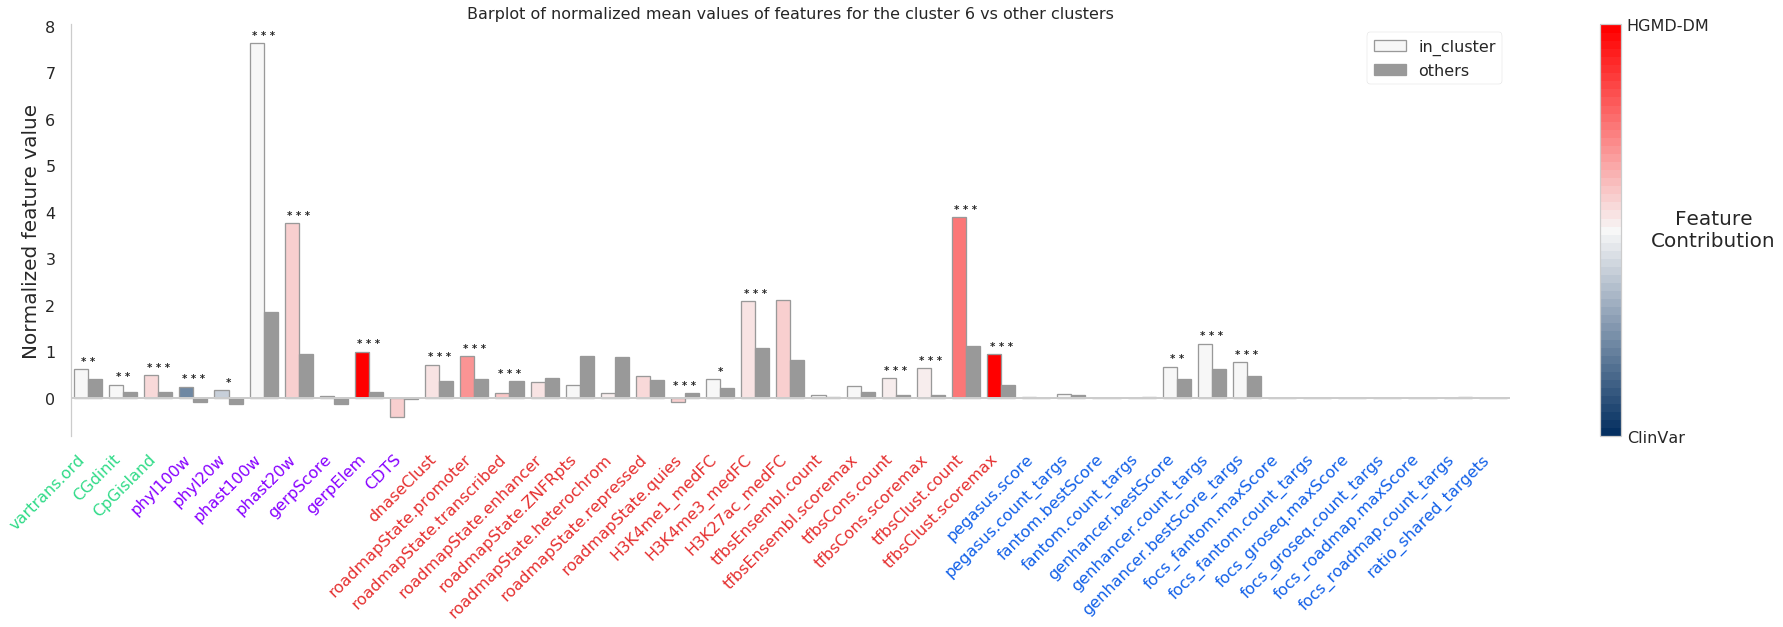

In [344]:
# Merged plot
color_feat_map = pd.Series([mpl.colors.rgb2hex(v) for v in cmap_HGMD(normlize_function_overall_variants(cluster_features_df['feature_contribution'].values))],
                           index=cluster_features_df.index.values).to_dict()

fig = plt.figure(figsize=(10+0.2*cluster_features_hue_df.shape[0],9))
ax1 = fig.add_subplot(1,1,1)
ML_visualization.barplot_normalized_differences(
    cluster_features_hue_df,
    model_columns,
    dict_feature_pvals,
    color_feat_map,
    ax=ax1)

for tick in ax1.get_xticklabels():
    tick.set_color(feature_colors[tick.get_text()])

ML_visualization.add_colorbar(ax1, cmap_HGMD, normlize, name_classes=['ClinVar','HGMD-DM'], color_class=1)
ax1.set_title("Barplot of normalized mean values of features for the cluster {} vs other clusters".format(index_cluster_to_plot))

ax1.set_ylabel("Normalized feature value")

plt.show()

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


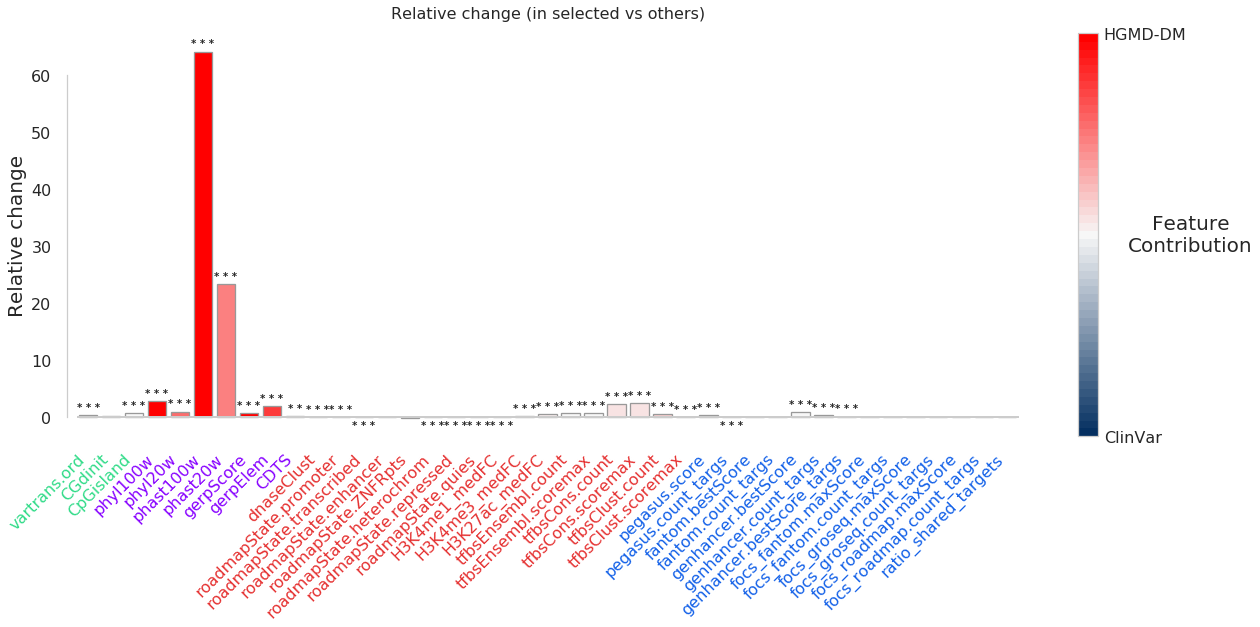

In [260]:
# DEMO RELATIVE CHANGE

# Note : normlize is a function that normalizes feature contribution values, basing on the entire distribution (and not only on values from the cluster)
# This means that the colors can be compared from one plot to another.

color_feat_map = pd.Series([mpl.colors.rgb2hex(v) for v in cmap_HGMD(normlize_function_overall_variants(cluster_features_df['feature_contribution'].values))],
                           index=cluster_features_df.index.values).to_dict()

fig = plt.figure(figsize=(10+0.2*cluster_features_df.shape[0],9))
ax1 = fig.add_subplot(1,1,1)
ML_visualization.barplot_relative_changes(cluster_features_df.replace(np.nan,0), model_columns, color_feat_map, dict_feature_pvals,ax=ax1)

for tick in ax1.get_xticklabels():
    tick.set_color(feature_colors[tick.get_text()])
    
ML_visualization.add_colorbar(ax1, cmap_HGMD, normlize, name_classes=['ClinVar','HGMD-DM'], color_class=1)
plt.show()

##### NOT DEMO : EXPORT PLOTS FOR ALL CLUSTERS

In [347]:
# We first build a normlize function from all the feature contributions calculated over the ENTIRE dataset.
all_contribs_values = X_kmeans.values.flatten()
all_contribs_values.sort()

normlize_function_overall_variants = ML_visualization.center_cmap(all_contribs_values,
                                                   robust=True,
                                                   center=0)

In [346]:
# Here : comment out one of the two blocks to generate plots comparing
# in-cluster positives vs out-cluster all variants (positives + negatives)
# OR
# in-cluster positives vs out-cluster positives (not considering negative examples.)

# This actually has no impact on the 


# Comparing POSITIVE samples from each cluster VS ALL OTHERS

comparison = '_VS-FULL-DATASET'
comparison_str = 'against full dataset'

tmp_X = X_trainset_positives_and_others.assign(
            true_class=(np.concatenate([y_trainset[y_trainset.astype(bool)],
                                        y_trainset[~y_trainset.astype(bool)]])),
            predicted_class=(np.concatenate([(feature_contribs_cl1['pred'].loc[y_trainset.astype(bool)]>optimal_thresholds['HGMDDM_cytoband']).astype(int),
                                             (feature_contribs_cl1['pred'].loc[~y_trainset.astype(bool)]>optimal_thresholds['HGMDDM_cytoband']).astype(int)
                                             ])))

tmp_selected_labels = selected_labels+['-1' for i in range((~y_trainset.astype(bool)).sum())]


# Comparing POSITIVE samples from each cluster VS OTHER POSITIVE SAMPLES ONLY:

# comparison = '_VS-OTHER-CLUSTERS'

# comparison_str = 'vs other clusters'

# tmp_X = mapper.fit_transform(X_trainset.loc[y_trainset.astype(bool),model_columns]
#                             ).assign(true_class=(y_trainset[y_trainset.astype(bool)]),
#                                      predicted_class=(feature_contribs_cl1['pred'].loc[y_trainset.astype(bool)]>optimal_thresholds['HGMDDM_cytoband']).astype(int))

# tmp_selected_labels = selected_labels

In [ ]:
path_results_feat_contribs_barplots = path_results_feat_contribs+'/k-means_K={}_per_cluster_barplot/'.format(N_selected_clusters)

if not os.path.exists(path_results_feat_contribs_barplots):
    os.makedirs(path_results_feat_contribs_barplots)
    
for i in range(len(set_selected_labels)):
    k_clust = str(i)
    
    (cluster_X,
    cluster_features_df,
    cluster_features_hue_df,
    order_features,
    dict_feature_pvals,
    normlize) = ML_visualization.get_data_from_cluster(
                                               i,
                                               relative_changes_clusters_norm,
                                               pvals_df_clusters_norm,
                                               long_merged_contribs_clusters,
                                               long_merged_features_clusters_norm,
                                                tmp_X,
                                                tmp_selected_labels)
    
    color_feat_map = pd.Series([mpl.colors.rgb2hex(v) for v in cmap_HGMD(normlize_function_overall_variants(cluster_features_df['feature_contribution'].values))],
                               index=cluster_features_df.index.values).to_dict()

    
    # We only extract the barplot of normalized features.
    fig = plt.figure(figsize=(10+0.2*cluster_features_hue_df.shape[0],9))
    ax1 = fig.add_subplot(1,1,1)
    ML_visualization.barplot_normalized_differences(
        cluster_features_hue_df,
        model_columns,
        dict_feature_pvals,
        color_feat_map,
        ax=ax1)

    for tick in ax1.get_xticklabels():
        tick.set_color(feature_colors[tick.get_text()])

    ML_visualization.add_colorbar(ax1, cmap_HGMD, normlize, name_classes=['ClinVar','HGMD-DM'], color_class=1)
    
    ax1.set_title("Barplot of normalized mean values of features for the cluster {} {}".format(k_clust, comparison_str))
    
    ylim_up = cluster_features_hue_df['value'].max()*1.05
    ylim_dn = cluster_features_hue_df['value'].min()*1.05
    #ax1.set_ylim(-0.68, 18.2)
    ax1.set_ylim(ylim_dn, ylim_up)
    ax1.set_ylabel("Normalized feature value")
    
    
    
    plt.savefig(path_results_feat_contribs_barplots+'cluster-{}_barplot_mean-feature_color-contribs{}.svg'.format(k_clust, comparison))
    
    plt.show()

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


### TP, FN, TN, FP

Before looking for structure in our datasets, we would like to see whether the feature contributions can help in understanding why some samples are mis-classified.

In [202]:
def classif_category(row):
    if row['true_class']==1:
        if row['pred_class']==1:
            return 'TP'
        else:
            return 'FN'
    else:
        if row['pred_class']==1:
            return 'FP'
        else:
            return 'TN'

Creating new figure


/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


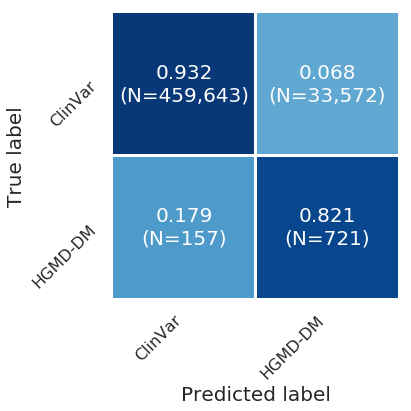

In [245]:
threshold = 0.55
classif_category_trainset = pd.concat([pd.Series((feature_contribs_cl1['pred']>threshold).astype(int).values,name='pred_class'),
                                       pd.Series(y_trainset,name='true_class')],axis=1).astype(int).apply(classif_category, axis=1)
dummies_classifcat = pd.get_dummies(classif_category_trainset).astype(bool)

ordered_classifcat = ('TP','FP','FN','TN')
list_classifcat = [dummies_classifcat.loc[:,cat].values for cat in ordered_classifcat]

ML_visualization.plot_confusion_matrix(sklearn.metrics.confusion_matrix(pd.Series(y_trainset,name='true_class'),pd.Series((feature_contribs_cl1['pred']>threshold).astype(int).values,name='pred_class')),
                                       classes=['ClinVar','HGMD-DM'],
                                       normalize=True,
                                      )#savefig_file=path_results_feat_contribs+"classifCategories_thresh=0.55_confusion-matrix.svg")                      

In [214]:
%%time

# Here: for each cluster, get the relative difference ratio between samples within the cluster against other samples.
# Use directly feature contributions, rather than normalized feature contributions.
(contribs_classifcats,
contribs_relative_changes_classifcats,
contribs_pvals_df_classifcats) = ML_tests.multiple_relative_changes(
                                    itt.repeat(X_kmeans,
                                               len(ordered_classifcat)),
                                    list_classifcat,
                                    {c:'continuous' for c in X_kmeans.columns.values} # Here we work with contributions, which are continuous distributions.
                                    )

# Create long format of this dataframe
long_merged_contribs_classifcats = pd.concat([ctb_df.reset_index().melt(id_vars='index').assign(classifcat=label)
                                           for ctb_df,label in zip(contribs_classifcats,ordered_classifcat)]
                                         ).reset_index(drop=True).set_axis(['feature','sample_set','value','classifcat'],
                                                                           axis=1,
                                                                           inplace=False)                 

CPU times: user 23.6 s, sys: 4 ms, total: 23.6 s
Wall time: 23.7 s


/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


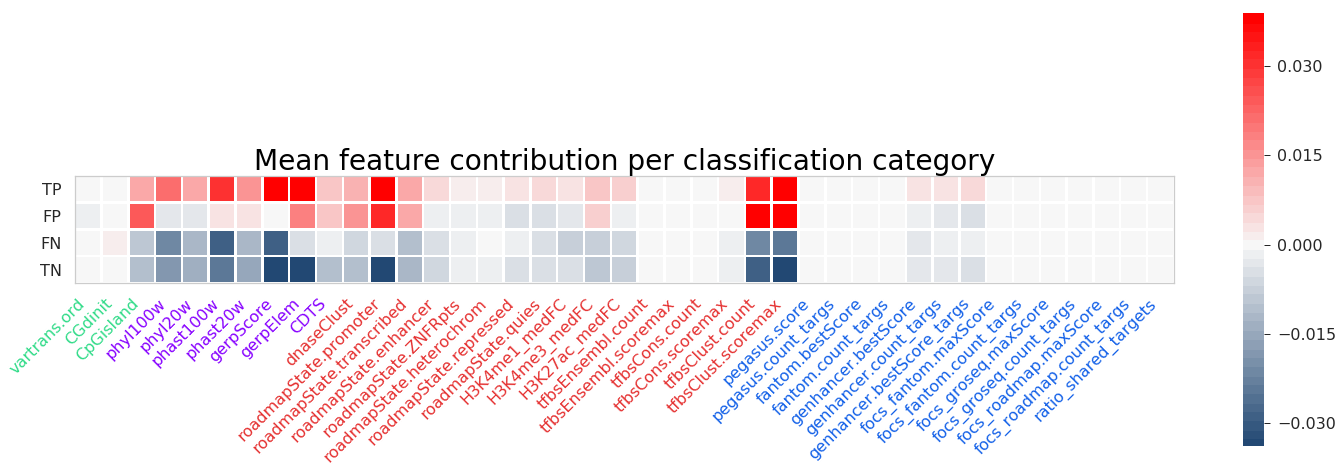

In [249]:
# Feature contributions mean value per classifcat

ML_visualization.heatmap_relative_changes(
     [df['selected'] for df in contribs_classifcats],
     heatmap_columns = ordered_classifcat,
     list_pvals_df=None,
     mask_nonsign=False,
     my_cmap = cmap_HGMD,
    feature_colors=feature_colors,
    title="Mean feature contribution per classification category",
    title_color='#000000',
    #savefig_file=path_results_feat_contribs+"classifCategories_thresh=0.55_heatmap_mean-feature-contribs.svg",
     show_plot=True
    )

In [231]:
%%time
# relative changes of feature values between clusters.
(summarized_classifcat,
relative_changes_classifcat,
pvals_df_classifcat) = ML_tests.multiple_relative_changes(
                        itt.repeat(X_trainset,
                                   len(ordered_classifcat)),
                        list_classifcat,
                        cols_type=col_types)

# Create long format of this dataframe
long_merged_features_classifcat = pd.concat([summarized_df.reset_index().melt(id_vars='index').assign(classficat=label)
                                           for summarized_df,label in zip(summarized_classifcat, ordered_classifcat)]
                                         ).reset_index(drop=True).set_axis(['feature','sample_set','value','classifcat'],
                                                                           axis=1,
                                                                           inplace=False)               

CPU times: user 14.2 s, sys: 4 ms, total: 14.3 s
Wall time: 14.3 s


/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


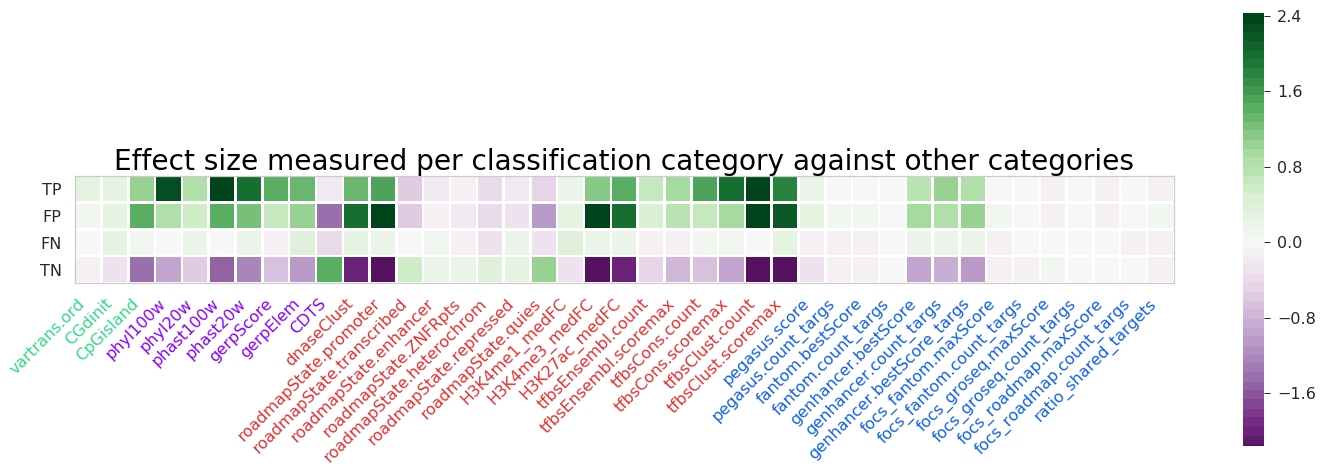

In [248]:
# Mean feature effect size (per classif-category vs full dataset

ML_visualization.heatmap_relative_changes(relative_changes_classifcat,
                                         ordered_classifcat,
                                         pvals_df_classifcat,
                                         mask_nonsign=False,
                                         feature_colors=feature_colors,
                                         my_cmap=cmap_enrichment,
                                         title="Effect size measured per classification category against other categories",
                                         title_color='#000000',
                                       #savefig_file=path_results_feat_contribs+"classifCategories_thresh=0.55_heatmap_effect-size.svg",
                                         show_plot=True
                                        )